📏 기준 Input Flux (Ag + 기판 + 공기): 0.131055


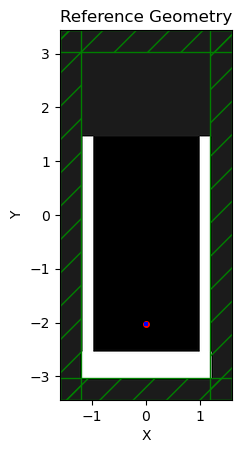

In [11]:
def Reference_structure(per_time=10,decay_rate = 1e-3):
    import meep as mp
    import numpy as np
    import matplotlib.pyplot as plt
    from meep.materials import Ag

    mp.verbosity(0)
    lambda_min = 0.4
    lambda_max = 0.7
    fmin = 1 / lambda_max
    fmax = 1 / lambda_min
    fcen = 0.5 * (fmin + fmax)
    df = fmax - fmin
    resolution = 50

    # 구조물 파라미터
    tag_bot = 0.5     # 하단 Ag 두께
    tsio2 = 4         # SiO₂ 기판 두께
    tpml = 0.4        # PML 두께
    design_region_height = 0.5

    monitor_position = 1 / fcen * 2
    monitor_blank = 1 / fcen * 0.1
    width_ag = 0.2
    width_sio2 = 2
    width_bot_ag = width_ag + width_sio2 + width_ag
    Sx = tpml + width_bot_ag + tpml
    Sy = round(tpml + tag_bot + tsio2 + design_region_height + monitor_position + monitor_blank + tpml, 3)
    cell_size = mp.Vector3(Sx, Sy)
    design_region_width = round(width_bot_ag, 3)

    # === 재료 정의 ===
    SiO2 = mp.Medium(index=1.45)
    Air = mp.Medium(index=1.0)

    # === 위치 계산 ===
    y_bottom = -Sy / 2
    center_y_ag = y_bottom + tpml + tag_bot / 2
    center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
    center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
    center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
    center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
    center_Ag_x_position = design_region_width / 2 - width_ag / 2

    # === geometry 정의 (기판 + Ag만 유지) ===
    geometry = [
        mp.Block(material=SiO2, size=mp.Vector3(width_sio2, tsio2, 0), center=mp.Vector3(0, center_y_sio2, 0)),
        mp.Block(material=Ag, size=mp.Vector3(width_bot_ag, tag_bot, 0), center=mp.Vector3(0, center_y_ag, 0)),
        mp.Block(
            material=Ag,
            size=mp.Vector3(width_ag, tsio2, 0),
            center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
        ),
        mp.Block(
            material=Ag,
            size=mp.Vector3(width_ag, tsio2, 0),
            center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
        ),
    ]

    # === PML 설정 (상하단 모두) ===
    boundary_layers = [
        mp.PML(tpml, direction=mp.X),
        mp.PML(tpml, direction=mp.Y, side=mp.Low),
        mp.PML(tpml, direction=mp.Y, side=mp.High)
    ]

    # === dipole 소스 ===
    source = mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(0, center_y_source_position, 0)
    )

    # === 시뮬레이션 설정 ===
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[source],
        default_material=Air
    )

    # === 4방향 flux monitor ===
    offset = 0.01
    flux_size = 0.02
    input_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=source.center - mp.Vector3(offset, 0), size=mp.Vector3(0, flux_size), weight=-1),
        mp.FluxRegion(center=source.center + mp.Vector3(offset, 0), size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=source.center - mp.Vector3(0, offset), size=mp.Vector3(flux_size, 0), weight=-1),
        mp.FluxRegion(center=source.center + mp.Vector3(0, offset), size=mp.Vector3(flux_size, 0))
    )

    # === 시뮬레이션 실행 ===
    sim.run(until_after_sources=mp.stop_when_fields_decayed(per_time, mp.Ez, source.center, decay_rate))

    # === 결과 출력 ===
    flux_value = mp.get_fluxes(input_flux)[0]
    print(f"📏 기준 Input Flux (Ag + 기판 + 공기): {flux_value:.6f}")

    # === geometry 시각화 ===
    sim.plot2D()
    plt.title("Reference Geometry")
    plt.show()

Reference_structure()